# Final Project FM








(Due Date: Jan 11, 2024, class time)



### FM modulation Functions


In [36]:
# -*- coding: utf-8 -*-
"""
Created on Sat Dec  2 15:31:47 2023
Finished on Thu Dec  7 17:44:30 2023

@author: Suhao Wang
"""

import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, fftfreq,fftshift,ifft
import math
    

# Define the message signal
def square_pulse(t,T1,dt,amplitude):
    return np.where((t >= T1-dt/2) & (t <= T1+dt/2), amplitude, 0)

# Generate the FM signal with kf, Fc and mt
def generate_fm_signal(t, Fs, m_t, mykf, myFc, Ac):
    # "np.cumsum(m_t) / Fs" is the integral "array" from -5 (the start of numpy array) to t
    phi_t = 2 * np.pi * myFc * t + 2*np.pi* mykf * np.cumsum(m_t) / Fs  # Phase deviation
    fm_signal = Ac*np.cos(phi_t)  # FM signal
    return fm_signal

### Numerical Approach
#   func. find_bandwidth integarte to get the approximated band width
#   The func. will return the approximated bandwidth。
#   1. calculate bandwidth from Fc to left until 0 and from fc to right until "infinite"
#   2. make sure that fc>fm+kf*Am
def calculate_bandwidth(f, Y, center, accuracy):
    # parameters
    step = (max(f) - min(f)) / len(f)
    n = len(Y)
    n_half = math.floor(n / 2)
    energy = np.zeros(n)
    df = f[1]-f[0]
    step = df
    ## df is 0.1, step 0.099995, but both seems good

    # total energy in positive axis
    energy[0] = step * math.pow(Y[0], 2)
    for i in range(1, n_half):
        energy[i] = energy[i - 1] + step * math.pow(Y[i], 2)

    # band_energy we need in positive axis
    total_energy = energy[n_half-1]
    band_energy = accuracy * total_energy
    
    # move
    center_index = (int)(center*1/step)
    energy[0] = step * math.pow(Y[center_index], 2)

    for i in range(1, n_half-center_index):
        energy[i] = energy[i - 1] + step * math.pow(Y[i+center_index], 2)
        if center_index-i>=0:
            energy[i] = energy[i] + step * math.pow(Y[center_index-i], 2)

        if (energy[i]>band_energy):
            if (center_index-i>=0):
                bandwidth = f[i+center_index]-f[center_index-i]
            else:
                bandwidth = f[i+center_index]
            break

    return round(bandwidth,3)


    
    


### FM demodulation functions

In [37]:
import numpy as np
from numpy.fft import fft, fftfreq,fftshift,ifft
import scipy.signal as signal
def discriminator(signal_t,Fs):
    fbin  = fftfreq(len(signal_t), d=1 / Fs)
    signal_f = fft(signal_t)/Fs
    differentiated_spectrum = (2*np.pi*1j*fbin) * signal_f 
    differentiated_signal = ifft(differentiated_spectrum).real*Fs
    result_t = np.abs(signal.hilbert(differentiated_signal))
    return result_t

def differentiate(signal_t,Fs):
    fbin  = fftfreq(len(signal_t), d=1 / Fs)
    signal_f = fft(signal_t)/Fs
    differentiated_spectrum = (2*np.pi*1j*fbin) * signal_f 
    differentiated_signal = ifft(differentiated_spectrum).real*Fs
    return differentiated_signal


def demodulation(t, recv_signal,Fs,fm_BT,m_bw,Fc,sampe_center=0):
    # band-pass filter
    # BPF的Bc意思是得到[fc-Bc/2,fc+Bc/2],h = 2Bcsinc(Bct)*cos(2pi*fc*t)
    Bc2 = fm_BT
    h_hp = 2*Bc2*np.sinc(Bc2*(t-sampe_center))*np.cos(2*np.pi*Fc*t)
    x_t2 = np.convolve(recv_signal, h_hp,'same')/Fs

    # limiter
    envelope = np.abs(signal.hilbert(x_t2))
    limited_t2 = 0.5*(2*x_t2-envelope)/envelope + 0.5

    # discriminator = differentiate + envelope detector 
    ## envelope = 2*pi*fc + 2*pi*kf*m_t
    envelope2 = discriminator(limited_t2,Fs) 
    v_t2 = (envelope2 - 2*np.pi*Fc)/(2*np.pi)

    # low-pass filter
    # LPF的Bc意思是得到[-Bc,Bc],h = 2Bcsinc(2Bct)
    Bc = m_bw          
    h_lp = 2*Bc*np.sinc(2*Bc*(t-sampe_center))
    output_t2 = np.convolve(v_t2,h_lp,'same')/Fs  #归一化

    return x_t2,limited_t2,v_t2,output_t2


![final project FM block diagram.PNG](<attachment:final project FM block diagram.PNG>)
Note: 
1. assume discriminator = differentiate + envelope detector, then envelope2 is the direct output of discriminator. v(t) needs more operation to get.
2. Blue part is not used in the code. We assume that $recv_t = fm_t + w_t$ directly. In practice, the $fm_t$, centering at $Fc$, should be moved to $Fc+Fr$. Radio transmission requires larger frequency.
3. limiter will use the Auxiliary Angle formula and delete the original amplitude of $x\_t$ which is useless.
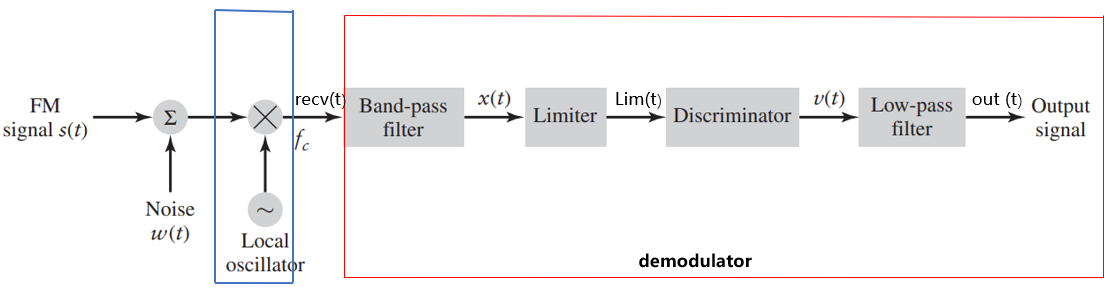

$x\_t = fm\_t + n\_t$, where $n\_t$ is passing BPF w_t

$limited\_t = cos(2*\pi*fc*t+\theta(t))$, where $\theta$ is shown below:

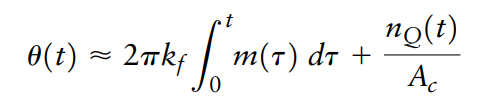

$envelope2 = 2*\pi*fc + 2*\pi*kf*m\_t + 2*\pi*nd\_t$

$v\_t = kf*m\_t + nd\_t$

$output\_t = kf*m\_t$

### plt function

In [38]:
import numpy as np
import matplotlib.pyplot as plt
def draw(t, signal_t, f, signal_f, signal_name,tmin=-2.5,tmax=2.5,fmin=-150,fmax=150):
    plt.figure(figsize=(16, 8))
    plt.subplot(2, 1, 1)
    plt.plot(t, signal_t)
    plt.title(signal_name)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.xlim(tmin,tmax)  
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.plot(fftshift(f), np.abs(fftshift(signal_f)))
    plt.title(signal_name)
    plt.xlabel('frequency(Hz)')
    plt.ylabel('magnitude')
    plt.xlim(fmin,fmax)  
    plt.grid()

## 1. Single Call

### Global Parameters

In [39]:
# numerical values
T = 5
Fs = 2000                   # Sampling frequency (Hz)
t = np.arange(-T, T, 1/Fs)  # 1/Fs is the interval

# message signal
duration = 4  # rect(t/duration)
Am = 1        # the rectangular pulse amplitude is fixed to 1
m_t = square_pulse(t,0,duration,Am)

# meesage signal frequency domain
m_fbin = fftfreq(len(m_t), d=1 / Fs)
m_f = fft(m_t)/Fs   #非周期函数归一化要乘以1/fs

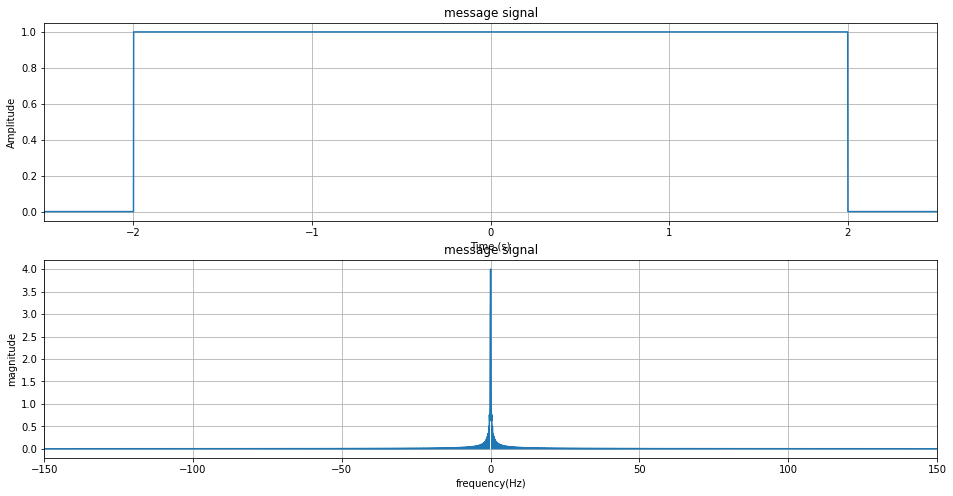

In [40]:
draw(t,m_t,m_fbin,m_f,"message signal")

### modulation
notice that $Fc$ should be larger than $kf*Am$ and $T$ should be larger than $duration/2$


In [41]:
# Define the parameters

Fc = 70       # Carrier frequency (Hz)
kf = 30       # Frequency sensitivity (Hz/Volt), 
Ac = 1       # carrier amplitude

# fm_signal
fm_t = generate_fm_signal(t, Fs, m_t, kf, Fc, Ac)

# fm_signal frequency domain
fm_fbin = fftfreq(len(fm_t), d=1 / Fs)
fm_f = fft(fm_t)/Fs   #FM 信号虽然是cos，但是仍然是非周期函数


# test the bandwidth
fm_bw = calculate_bandwidth(fm_fbin,abs(fm_f),Fc,0.999)
m_bw = calculate_bandwidth(m_fbin,abs(m_f), 0, 0.999)     
print(fm_bw)
print(m_bw)

66.2
18.1


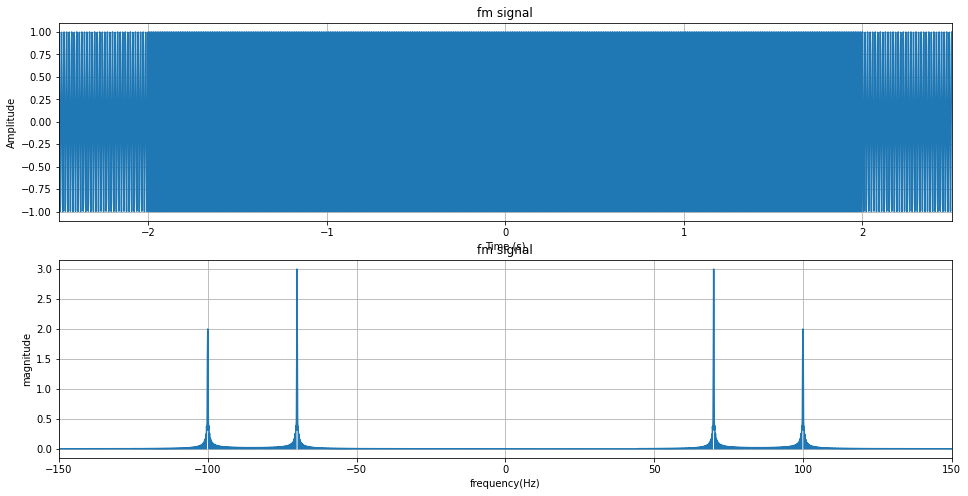

In [42]:
draw(t,fm_t,fm_fbin,fm_f,"fm signal")

### demodulation without noise

In [43]:

# add noise
recv_t2 = fm_t

# demodulation
x_t2, limited_t2, v_t2, output_t2 = demodulation(t, recv_t2, Fs, fm_bw, m_bw, Fc, sampe_center=0)


### Noisy signal demodulation

In [44]:
import numpy as np
from numpy.fft import fft, fftshift

# add noise
noise_size = 0.1
w_t = noise_size*np.random.randn(t.size)
recv_t = w_t + fm_t


# demodulation
x_t, limited_t, v_t, output_t = demodulation(t, recv_t, Fs, fm_bw, m_bw, Fc, sampe_center=0)


# get freq domain
recv_f = fft(recv_t)/Fs  
x_f = fft(x_t)/Fs
limited_f = fft(limited_t)/Fs
v_f = fft(v_t)/Fs
output_f = fft(output_t)/Fs


### plot figures

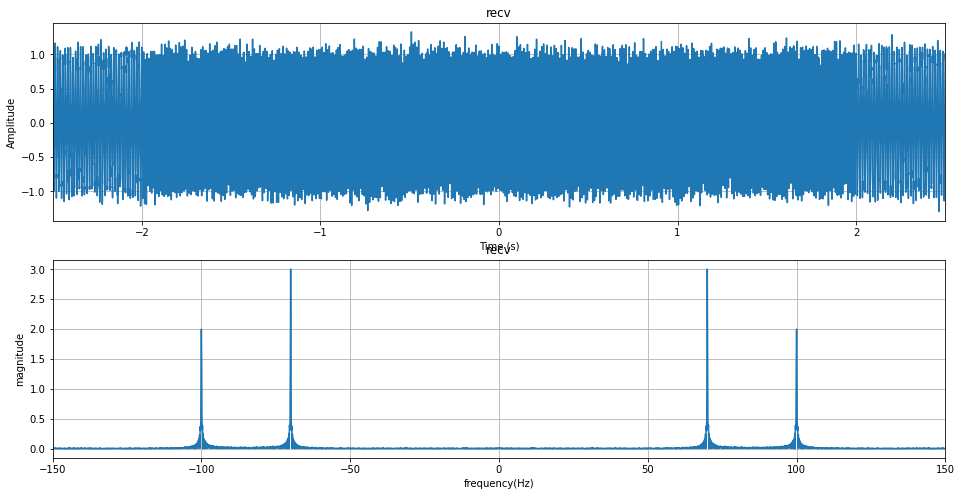

In [45]:
draw(t,recv_t,fm_fbin,recv_f,'recv')

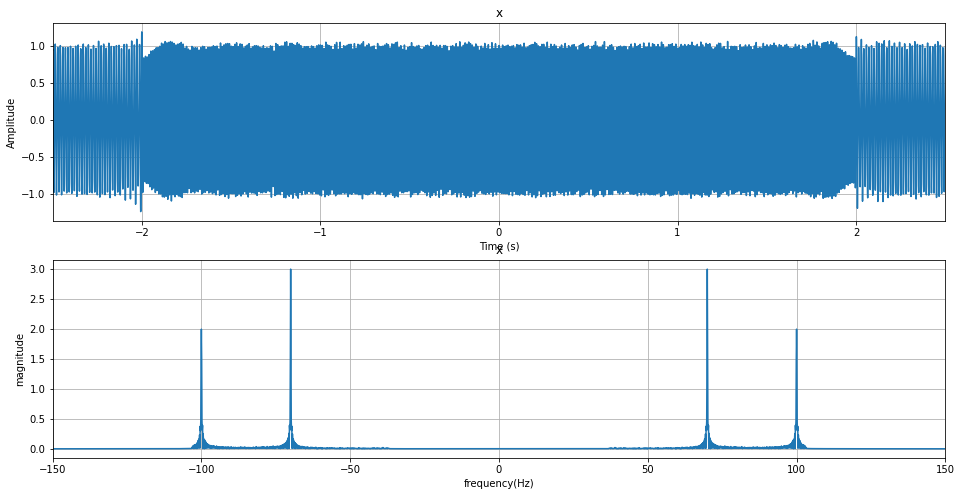

In [46]:

draw(t,x_t,fm_fbin,x_f,"x")

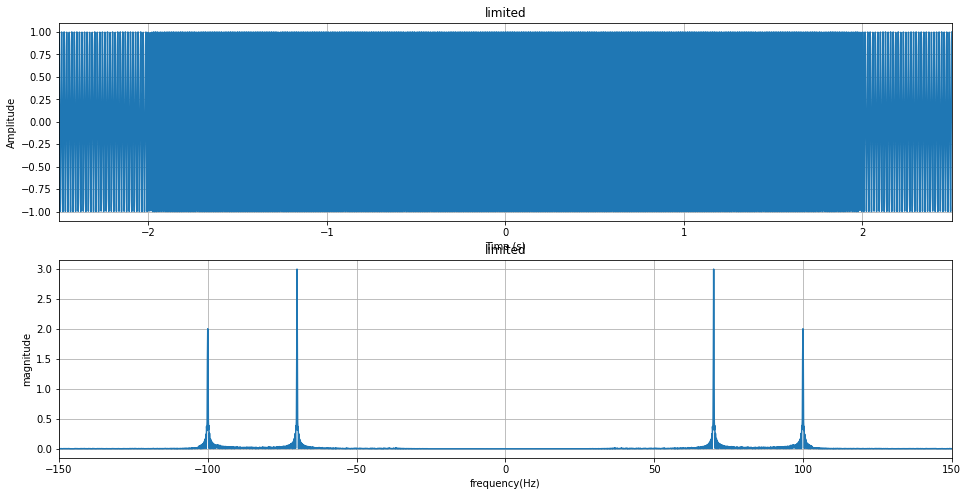

In [47]:

draw(t,limited_t,fm_fbin,limited_f,"limited")

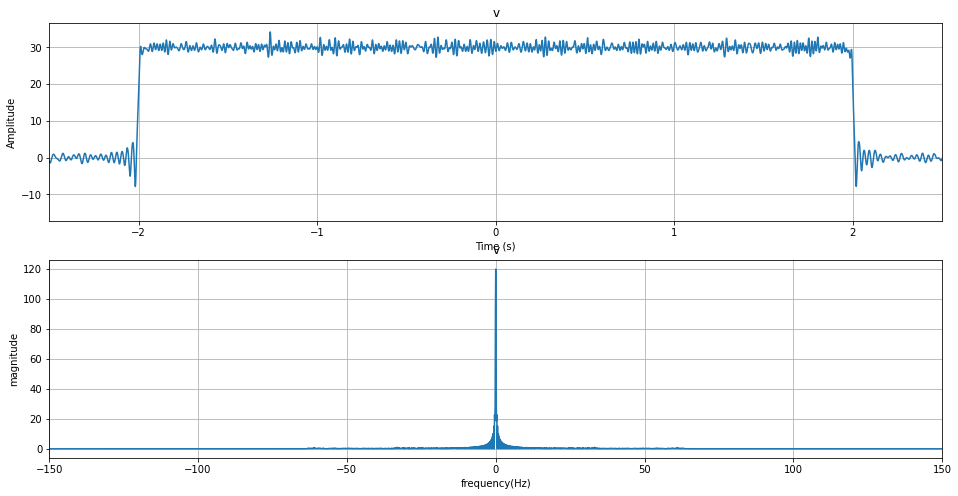

In [48]:

draw(t,v_t,fm_fbin,v_f,"v")


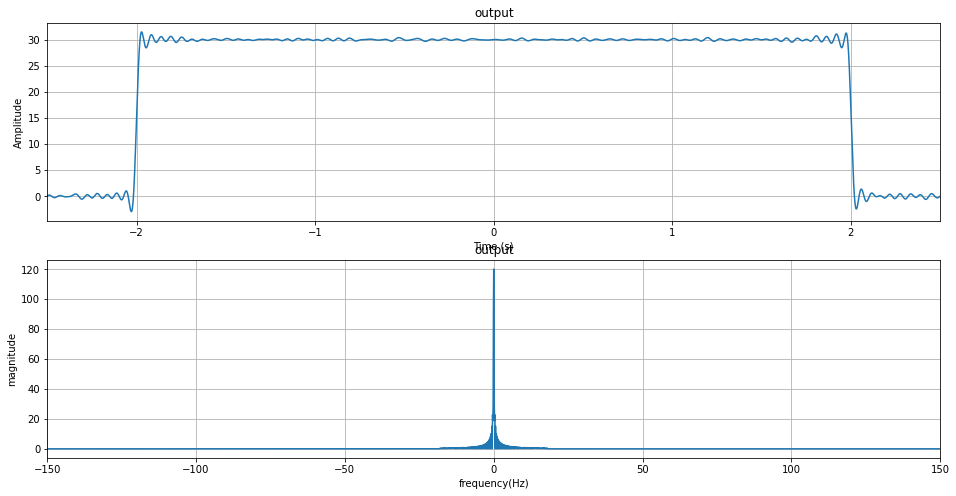

In [49]:

draw(t,output_t,fm_fbin,output_f,"output")

## 2. Appendix

### limiter test

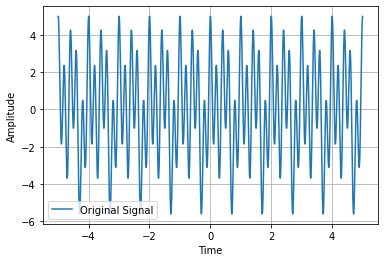

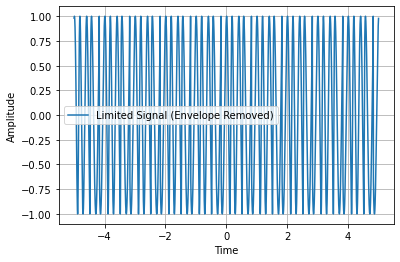

In [50]:
import numpy as np
import scipy.signal as signal
from scipy import fftpack
import matplotlib.pyplot as plt

original_signal = np.sin(2*np.pi*1*t) + 2*np.cos(2*np.pi*2*t)+3*np.cos(2*np.pi*5*t)

# envelope detector method 1
hx =fftpack.hilbert(original_signal)
hy = np.sqrt(original_signal**2+hx**2)

# envelope detector method 2, hy = envelope
envelope = np.abs(signal.hilbert(original_signal))

limiter_signal = 0.5*(2*original_signal-envelope)/envelope + 0.5

# Plot the original signal and the limited signal (with removed envelope)
plt.figure()
plt.plot(t, original_signal, label='Original Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

plt.figure()
plt.plot(t, limiter_signal, label='Limited Signal (Envelope Removed)')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()


plt.show()